# Oscilloscope Analaysis for Lab 28

#### Header info

In [1]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq

#Read in the runlist and save as dataframe
Runlist= pd.read_table("./Runlist.tsv")
Runlist["RN"]=pd.to_numeric(Runlist["RN"])

#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


## Functions 

In [2]:


#def grab_waveform_avg(waveform_path):
if 1==1:
    Runs=[]

    if 1==1:
        #print(waveform_path)
        dirlist = glob.glob(waveform_path+"*")
        #print(dirlist)
        for  dir in dirlist:
            dir = dir.replace("\\","/")
            subname= dir.replace(waveform_path,"")
            delim="-"
            name_sep= subname.split(delim)
            
            subname=subname.replace("\\","")
            subname=subname.replace(str(waveform_date),"")
            subname=subname.replace("%sL"%(delim),"L")
                 
            if "noise" in dir:
                LaserCur=0
                Voltags=[0,0,0]
                        
            key="L"
            item =[ i for i in name_sep if i.find(key) >= 0]
            
            result=[ i.replace(key,"") for i in item ]
            LaserCur=result[0] if len(result)>0  else 0

            key="C"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            CathPot=  result[0] if len(result)>0  else 0
            print(subname,result)

            key="G"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            GridPot=  result[0] if len(result)>0  else 0

            key="A"
            item =[ i for i in name_sep if i.find(key) >= 0]
            result=[ i.replace(key,"") for i in item ]
            AnodePot=  result[0] if len(result)>0  else 0

            #print("check" ,spec_loc,Apos_end)
            #print(stringtest[:Apos_end])
            #if AnodePos

            Voltags=[CathPot,GridPot,AnodePot]
          

            #Build up file name from the base name and path
            subname=subname.replace("-n","n")
            #print(waveform_path)
            file_base=waveform_path+"/"+str(waveform_date)+delim +subname
            if subname.find("vac_uv")>=0:
                continue
            #print(file_base)
            file_list= glob.glob(file_base+"/*.csv")

            #print("list\n",file_list)
            #prepare list for each channel for every waveform
            waveforms=[]
            ChAs=[] 
            ChBs=[]
            ChCs=[]
            Times=[]
            #print(file_base)
            if len(file_list)<0:
                print("No files found")
                break
        #        return 0

            #Loop through each file(waveform) 
            print("Number of waveforms: ", len(file_list))
            for file in file_list:
                #print("/t",file)
                waveform=pd.read_csv(file,skiprows=[1,2])#Read in the csv info into datafram
                
                #Grab each column and build 2D array with time steps for each channel then appended through each waveform
                Times.append(np.array(waveform["Time"]))
                ChAs.append(np.array(waveform["Channel A"]))
                ChBs.append(np.array(waveform["Channel B"]))
                ChCs.append(np.array(waveform["Channel C"]))
                

                            
            #average each channel
            Time=np.average(Times, axis=0)
            ChA=np.average(ChAs, axis=0)*1000
            ChB=np.average(ChBs, axis=0)
            ChC=np.average(ChCs, axis=0)

            waveform_dict={}
            waveform_dict["Time"]=Time
            waveform_dict["Pickoff"]=ChA
            waveform_dict["PreAmp"]=ChB
            waveform_dict["Shaper"]=ChC

            waveform_dict["LaserCur"]=LaserCur
            waveform_dict["Cathode"]=int(Voltags[0])
            waveform_dict["Grid"]   =int(Voltags[1])
            waveform_dict["Anode"]  =int(Voltags[2])
            waveform_dict["Info"]   =name_sep[-2]+"-" +name_sep[-1]
 
        # print(waveform_dict["LaserCur"])
            Runs.append(waveform_dict)
        print(len(Runs))
    #    return waveform_dict


#        return Runs



NameError: name 'waveform_path' is not defined

In [36]:
waveform_date=20231110
waveform_path="%s%s"%(env_var_waveformloc_old,str(waveform_date))

Runs= grab_waveform_avg(waveform_path)


C:/Users/KK_Lab28_1/Documents/Waveforms/20231110
[]
0


In [33]:
print(waveform_path[-1])


glob.glob("C:/Users/KK_Lab28_1/Documents/Waveforms/20231110*")

0


['C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-cathode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L23-C200-G0-A0-grid',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L24-C300-G0-A0-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L25-C1000-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L25-C500-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-L26-C250-G0-A100-anode',
 'C:/Users/KK_Lab28_1/Documents/Waveforms\\20231110-noise']

# Analysis

# July 10th data

## Run 1 = vac

Text(0.5, 1.0, 'Vac signal on 20240711')

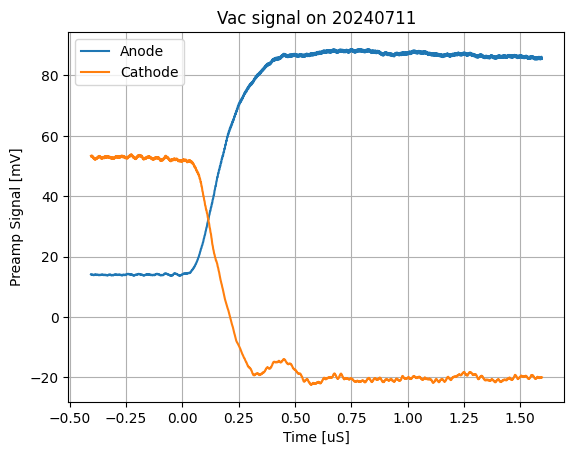

In [37]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="0001"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

Text(0.5, 1.0, 'Vac signal on 20240711')

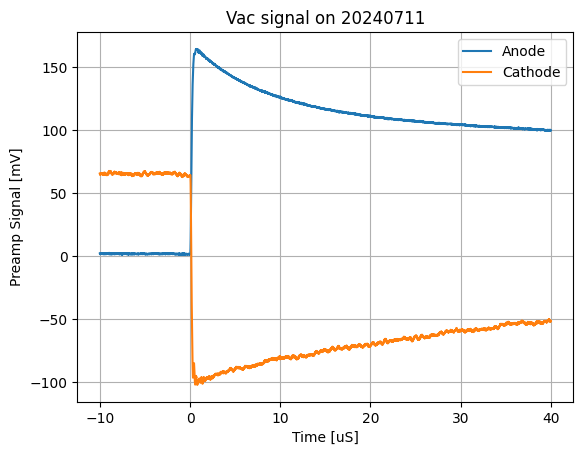

In [40]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

## Run 3

Text(0.5, 1.0, 'Vac signal on 20240711')

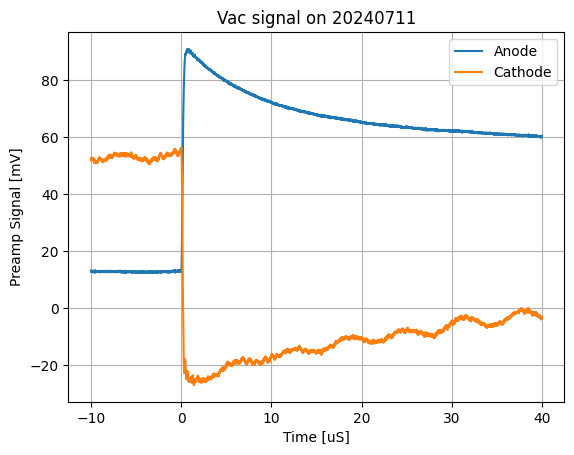

In [41]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00003"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

## Run 4

Text(0.5, 1.0, 'Vac signal on 20240711')

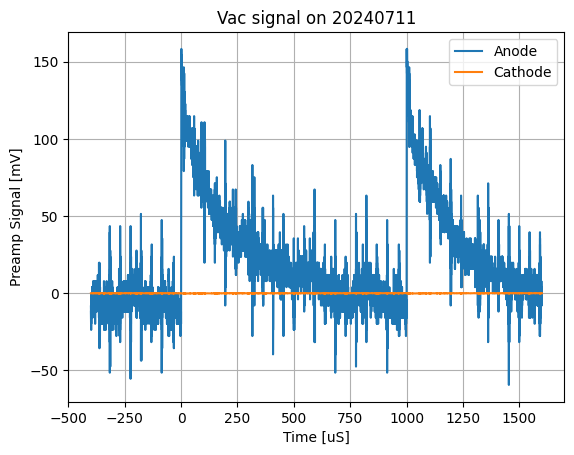

In [48]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00004"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="2"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV
DF["Time"]=DF["Time"]*1000 # Change from mS to uS


plt.errorbar(x=DF["Time"],y=DF["Channel Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Channel UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")